In [85]:
import json
# import sys
# sys.path.append("..")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict, Counter, namedtuple
from pathlib import Path

In [86]:
PATH = Path("../experiments-paper/6mer/07_25_2024-autoencoder/cross-validation/mean_squared_error-relu-relu-1-fold/faiss-embeddings")
N_MOST_COMMON=20

In [87]:
path_embeddings = PATH.joinpath("embeddings.npy") 
embeddings = np.load(path_embeddings)

In [88]:
path_id_embeddings = PATH.joinpath("id_embeddings.json") 
path_labels = PATH.joinpath("labels.json") 

In [89]:
with open(path_id_embeddings) as fp:
    id_embeddings = [l for l in json.load(fp).values()]

In [90]:
with open(path_labels) as fp:
    list_labels = [l for l in json.load(fp).values()]

In [91]:
from collections import Counter 
count = Counter(list_labels)

In [92]:
most_common = count.most_common(N_MOST_COMMON)
order_labels = [x[0] for x in most_common]


In [93]:
import pandas as pd 

df = pd.DataFrame({"path": id_embeddings, "label": list_labels})

In [94]:
embs = []
idxs = []
labels = []

for l, c in most_common:
    idx = df.query(f"label == '{l}'").index.tolist()[:1000]

    for _idx in idx:
        embs.append(embeddings[_idx,:])
        labels.append(l)
        idxs.append(_idx)


In [95]:
df.loc[idxs,:].value_counts(subset="label")

label
acinetobacter_baumannii       1000
campylobacter_coli            1000
campylobacter_jejuni          1000
clostridioides_difficile      1000
enterococcus_faecium          1000
escherichia_coli              1000
klebsiella_pneumoniae         1000
legionella_pneumophila        1000
listeria_monocytogenes        1000
mycobacterium_tuberculosis    1000
mycobacteroides_abscessus     1000
neisseria_gonorrhoeae         1000
neisseria_meningitidis        1000
pseudomonas_aeruginosa        1000
salmonella_enterica           1000
staphylococcus_aureus         1000
streptococcus_agalactiae      1000
streptococcus_pneumoniae      1000
streptococcus_pyogenes        1000
vibrio_cholerae               1000
Name: count, dtype: int64

In [96]:
from collections import namedtuple
InfoDist = namedtuple("InfoDist",["label","emb1","emb2","distance"])
distances = []

In [97]:
for label in order_labels:

    idx_label = [j for j,l in enumerate(labels) if l == label ]
    for pos1,idx1 in enumerate(idx_label[:-1]):
        emb1 = embs[idx1]
        for pos2,idx2 in enumerate(idx_label[pos1+1:]):
            emb2 = embs[idx2]
            distance = np.linalg.norm(emb1-emb2)
            distances.append(
                InfoDist(label,idx1,idx2,distance)
            )

df_distances = pd.DataFrame(distances)

In [98]:
df_distances

,label,emb1,emb2,distance
0,salmonella_enterica,0,1,0.060608
1,salmonella_enterica,0,2,0.068678
2,salmonella_enterica,0,3,0.047169
3,salmonella_enterica,0,4,0.102176
4,salmonella_enterica,0,5,0.060414
...,...,...,...,...
9989995,legionella_pneumophila,19996,19998,0.029901
9989996,legionella_pneumophila,19996,19999,0.029976
9989997,legionella_pneumophila,19997,19998,0.021390
9989998,legionella_pneumophila,19997,19999,0.044560


<Axes: xlabel='distance', ylabel='label'>

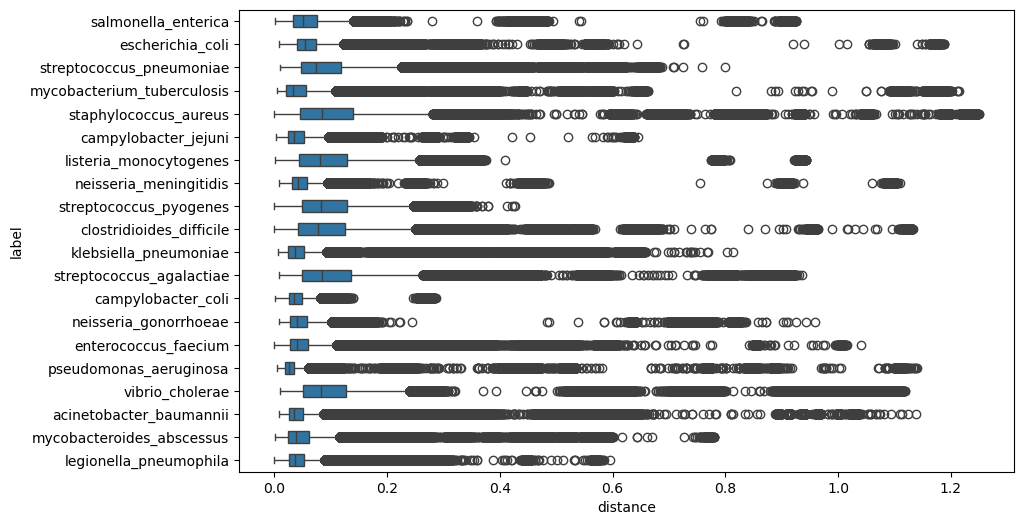

In [99]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_distances[["label","distance"]], y="label", x="distance", orient="h", order=order_labels,  width=.5)

___
Cluster map

In [100]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc


In [101]:
centroids = [] 

for label in order_labels:

    idx_label = [j for j,l in enumerate(labels) if l == label ]

    embs_label = [embs[idx] for idx in idx_label]

    centroid = np.vstack(embs_label).mean(axis=0)
    centroids.append(centroid)


In [102]:
n_labels = len(order_labels)
distance_matrix = np.zeros((n_labels,n_labels))

for pos1,l1 in enumerate(order_labels):
    emb1 = centroids[pos1]
    for pos2,l2 in enumerate(order_labels[pos1+1:]):
        emb2 = centroids[pos2+pos1+1]
        distance = np.linalg.norm(emb1-emb2)
        
        distance_matrix[pos1, pos2+pos1+1] = distance

distance_matrix +=distance_matrix.T
distance /= 2

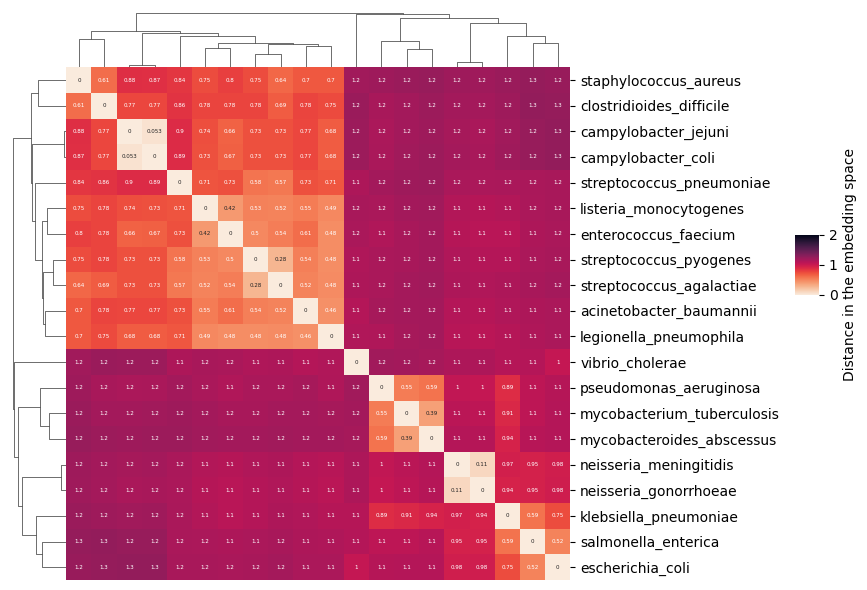

In [110]:
linkage = hc.linkage(sp.distance.squareform(distance_matrix), method='average')
g_clust = sns.clustermap(
    pd.DataFrame(distance_matrix, index=order_labels, columns=order_labels), 
    xticklabels=False,
    row_linkage=linkage, col_linkage=linkage, 
    annot=True, annot_kws={"size": 4},
    cmap="rocket_r",
    vmin=0, vmax=2, figsize=(8,6), 
    cbar_pos=(1, 0.5, .03, .1),
    dendrogram_ratio=(.1, .1),
    cbar_kws={"label": "Distance in the embedding space"}
    )

# ax = g_clust.ax_heatmap
# ax.set_xlabel("")